In [2]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=02d27667da2e1e8aa80fb10a4cb995773a3078f4082974e8bd46e6537b27f186
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [1]:
import os
import numpy as np
import zipfile as zf
import pandas as pd
import glob
import random
from pathlib import Path
import re
import shutil
import python_speech_features as mfcc
from scipy.io import wavfile
from matplotlib import pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -o -q "/content/drive/MyDrive/Recordings_ML/Recordings.zip" -d "/content/drive/MyDrive/ML_PHASE2/"

In [4]:
data = []
for filename in glob.glob(os.path.join('/content/drive/MyDrive/ML_PHASE2/Recordings','*.wav')):
  data.append(filename)

In [5]:
len(data)

16840

In [6]:
random.shuffle(data)
len(data)

16840

In [7]:
urdu = []
english = []
mix = []

In [8]:
for i in range(len(data)):
    if(re.findall(r"ur",data[i].split('/')[6])):
        urdu.append(data[i])
    elif(re.findall(r"en",data[i].split('/')[6])):
        english.append(data[i])
    else:
        mix.append(data[i])

In [9]:
print(len(urdu))
print(len(english))
print(len(mix))

5160
5132
6548


In [10]:
train = []
test = []

In [11]:
train.append(urdu[0:int(0.8*len(urdu))])
train.append(english[0:int(0.8*len(english))])
train.append(mix[0:int(0.8*len(mix))])
test.append(urdu[int(0.8*len(urdu)):])
test.append(english[int(0.8*len(english)):])
test.append(mix[int(0.8*len(mix)):])

In [12]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [13]:

train = flatten(train)
test = flatten(test)
random.shuffle(train)
random.shuffle(test)

In [14]:
print(len(train))
print(len(test))

13471
3369


In [15]:
rm -rf 'Phase2'

In [16]:
os.makedirs("Phase2")
os.makedirs("Phase2/Train")
os.makedirs("Phase2/Test")

In [17]:
for i in range(len(train)):
  shutil.copy(train[i],'/content/Phase2/Train')

In [18]:
for i in range(len(test)):
  shutil.copy(test[i],'/content/Phase2/Test')

In [19]:
sub_folders = [f.path for f in os.scandir('Phase2') if f.is_dir()]
sub_folders

['Phase2/Train', 'Phase2/Test']

In [20]:
def readfile(folder):
    audio = []
    sr = []
    label = []
    for filename in glob.glob(os.path.join(folder,'*.wav')):
        if filename.split('/')[2][:2] == 'en':
            label.append(0)
        elif filename.split('/')[2][:2] == 'ur':
            label.append(1)
        else:
            label.append(2)
        samplerate, data = wavfile.read(filename)
        audio.append(data)
        sr.append(samplerate)
    return audio,sr,label

In [21]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [22]:
def get_feature(audio,sr):
    feature = []
    for i in range(len(audio)):
        feature.append(get_MFCC(audio[i], sr[i]))
    return feature

In [23]:
def insert_bias(features):
    f = []
    xo = 1
    for i in range(len(features)):
        f.append(np.insert(features[i],0,xo,axis=0))
    return f

In [24]:
X_train_audio,X_train_sr,y_train = readfile(sub_folders[0])
X_test_audio,X_test_sr,y_test = readfile(sub_folders[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if sys.path[0] == '':


In [25]:
print(len(X_train_audio))
print(len(X_train_sr))
print(len(X_test_audio))
print(len(X_test_sr))

13471
13471
3369
3369


In [26]:
features = get_feature(X_train_audio, X_train_sr)
X_train = insert_bias(features)
features = get_feature(X_test_audio, X_test_sr)
X_test = insert_bias(features)

In [27]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13471, 14)
(13471,)
(3369, 14)
(3369,)


In [29]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [30]:
k_range = range(1, 11)
a_score = []
f_score = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  a = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
  f = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
  a_score.append(a.mean())
  f_score.append(f.mean())

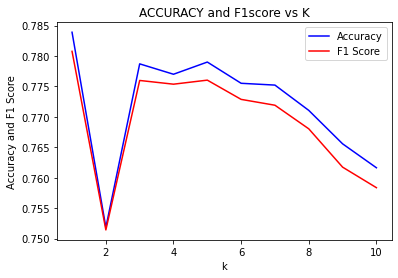

In [31]:
plt.plot(k_range, a_score, "-b", label="Accuracy")
plt.plot(k_range, f_score, "-r", label="F1 Score")
plt.title('ACCURACY and F1score vs K')
plt.xlabel('k')
plt.ylabel('Accuracy and F1 Score')
plt.legend(loc="upper right")
plt.show()

In [33]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
a = accuracy_score(y_test, pred)
c = confusion_matrix(y_test, pred)
f1score = f1_score(y_test, pred, average='macro')
print('Accuracy:',a)
print('F1 score:',f1score)
print('Confusion Matrix:')
print(c)

Accuracy: 0.7960819234194123
F1 score: 0.7934924320179918
Confusion Matrix:
[[ 835   85  107]
 [ 164  772   96]
 [ 152   83 1075]]


In [46]:
from sklearn.model_selection import validation_curve
s = svm.SVC(kernel='rbf',gamma = 0.01, C = 10)
score = cross_val_score(s, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

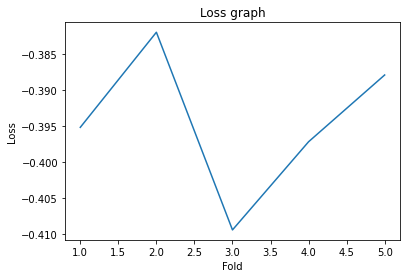

In [51]:
# import sklearn
import numpy as np
# sorted(sklearn.metrics.SCORERS.keys())
x = np.arange(1,len(score)+1,1)
plt.plot(x,score)
plt.title('Loss graph')
plt.xlabel('Fold')
plt.ylabel('Loss')
# plt.legend(loc="upper right")
plt.show()

In [52]:
s = svm.SVC(kernel='rbf',gamma = 0.01,C = 10)
s.fit(X_train, y_train)
pred = s.predict(X_test)
a = accuracy_score(y_test, pred)
c = confusion_matrix(y_test, pred)
f1score = f1_score(y_test, pred, average='macro')
print('Accuracy:',a)
print('F1 score:',f1score)
print('Confusion Matrix:')
print(c)

Accuracy: 0.8138913624220837
F1 score: 0.8112335429620371
Confusion Matrix:
[[ 802  110  115]
 [ 111  840   81]
 [ 123   87 1100]]


In [53]:
nn = MLPClassifier(hidden_layer_sizes=([1500,1000,500,250,120,50,20]), random_state=42, max_iter = 10000,activation='relu')
score = cross_val_score(nn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

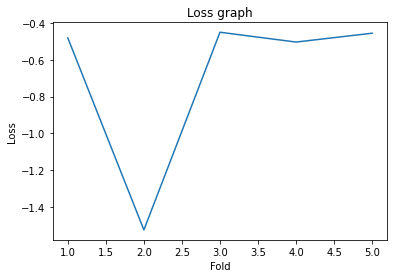

In [55]:
x = np.arange(1,len(score)+1,1)
plt.plot(x,score)
plt.title('Loss graph')
plt.xlabel('Fold')
plt.ylabel('Loss')
# plt.legend(loc="upper right")
plt.show()

In [54]:
nn = MLPClassifier(hidden_layer_sizes=([1500,1000,500,250,120,50,20]), random_state=42, max_iter = 10000,activation='relu')
nn.fit(X_train, y_train)
pred = nn.predict(X_test)
a = accuracy_score(y_test, pred)
c = confusion_matrix(y_test, pred)
f1score = f1_score(y_test, pred, average='macro')
print('Accuracy:',a)
print('F1 score:',f1score)
print('Confusion Matrix:')
print(c)

Accuracy: 0.7747105966162066
F1 score: 0.7723995954388848
Confusion Matrix:
[[ 752  165  110]
 [ 107  846   79]
 [ 137  161 1012]]
